# Detectron2 Crack Detection Training 

# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

     |████████████████████████████████| 276kB 11.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=e2049ae990d8a07354b4ad7620629034eb9d73d6edff468b8996b8931962d518
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True


In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 495kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=9128ab8c5d6d1eefe67ca06c55a0144cc4c55d6b3aa0dcb97428e162765717f8
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!unzip data.zip

Archive:  data.zip
  inflating: data/detectron2.json    
   creating: data/train/
  inflating: data/train/00145.jpg    
  inflating: data/train/00145.json   
  inflating: data/train/00146.jpg    
  inflating: data/train/00146.json   
  inflating: data/train/00147.jpg    
  inflating: data/train/00147.json   
  inflating: data/train/00148.jpg    
  inflating: data/train/00148.json   
  inflating: data/train/00149.jpg    
  inflating: data/train/00149.json   
  inflating: data/train/00150.jpg    
  inflating: data/train/00150.json   
  inflating: data/train/00151.jpg    
  inflating: data/train/00151.json   
  inflating: data/train/00152.jpg    
  inflating: data/train/00152.json   
  inflating: data/train/00153.jpg    
  inflating: data/train/00153.json   
  inflating: data/train/00154.jpg    
  inflating: data/train/00154.json   
  inflating: data/train/00155.jpg    
  inflating: data/train/00155.json   
  inflating: data/train/00156.jpg    
  inflating: data/train/00156.json   
  infl

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain", {}, "./data/detectron2.json", "./data/train")

In [6]:
sample_metadata = MetadataCatalog.get("customtrain")
dataset_dicts = DatasetCatalog.get("customtrain")

WARNING [04/09 09:02:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 09:02:53 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./data/detectron2.json


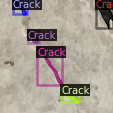

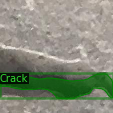

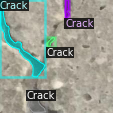

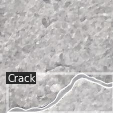

In [7]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[04/09 09:07:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:15, 11.5MB/s]                          
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due t

[04/09 09:07:36 d2.engine.train_loop]: Starting training from iteration 0
[04/09 09:07:57 d2.utils.events]:  eta: 0:04:51  iter: 19  total_loss: 3.802  loss_cls: 2.539  loss_box_reg: 0.469  loss_mask: 0.6833  loss_rpn_cls: 0.01185  loss_rpn_loc: 0.01348  time: 1.0306  data_time: 0.0152  lr: 4.9952e-05  max_mem: 1861M
[04/09 09:08:17 d2.utils.events]:  eta: 0:04:28  iter: 39  total_loss: 2.159  loss_cls: 0.8354  loss_box_reg: 0.5937  loss_mask: 0.5749  loss_rpn_cls: 0.02959  loss_rpn_loc: 0.01455  time: 1.0244  data_time: 0.0075  lr: 9.9902e-05  max_mem: 1861M
[04/09 09:08:37 d2.utils.events]:  eta: 0:04:02  iter: 59  total_loss: 1.35  loss_cls: 0.3183  loss_box_reg: 0.566  loss_mask: 0.428  loss_rpn_cls: 0.01293  loss_rpn_loc: 0.01398  time: 1.0168  data_time: 0.0072  lr: 0.00014985  max_mem: 1861M
[04/09 09:08:57 d2.utils.events]:  eta: 0:03:42  iter: 79  total_loss: 1.221  loss_cls: 0.2533  loss_box_reg: 0.6235  loss_mask: 0.3129  loss_rpn_cls: 0.003356  loss_rpn_loc: 0.007804  time:

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain", )
predictor = DefaultPredictor(cfg)

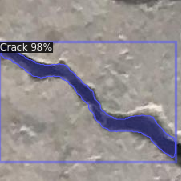

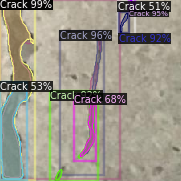

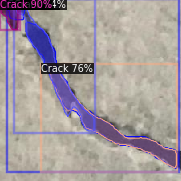

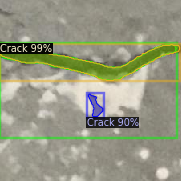

In [11]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

### Evaluation
We can evaluate its performance using AP metric implemented in COCO API.


In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("customtrain", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "customtrain")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [04/09 09:31:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 09:31:58 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./data/detectron2.json
[04/09 09:31:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/09 09:31:58 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[04/09 09:31:58 d2.data.common]: Serialized dataset takes 0.19 MiB
[04/09 09:31:58 d2.evaluation.evaluator]: Start inference on 100 images
[04/09 09:32:02 d2.evaluation.evaluator]: Inference done 11/100. 0.2835 s / img. ETA=0:00:25
[04/09 09:32:07 d2.evaluation.evaluator]: Inference done 29/100. 0.2821 s / img. ETA=0:00:20
[04/09 09:32:12 d2.evaluation.evaluator]: Inference done 47/100. 0.2830 s / img. ETA=0:00:15
[04/09 09:32:17 d2.evaluation.evaluator]: Inference done 65

### Getting the custom config file

In [17]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

## ***Testing with sample image taken from google images***

---



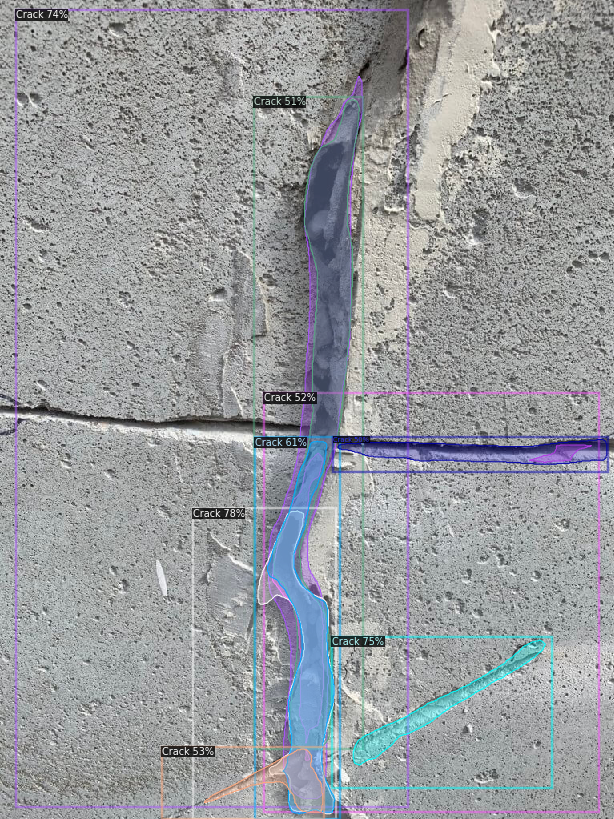

In [18]:
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("./crack.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=sample_metadata,scale=0.8,instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])